In [ ]:
# Hydro-Québec Consumption Analysis with Heating/Cooling Breakdown
# 
# This notebook estimates heating and cooling consumption based on temperature correlation
# 
# Requirements:
#     pip install hydroq-api pandas matplotlib python-dotenv numpy scipy

# ## 1. Setup and Authentication

from hydroq_api import HydroQuebec
from datetime import datetime, timedelta
import json
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import os
from dotenv import load_dotenv
from scipy import stats

In [2]:
# Load credentials from .env file
load_dotenv()

USERNAME = os.getenv('HYDRO_QUEBEC_USERNAME')
PASSWORD = os.getenv('HYDRO_QUEBEC_PASSWORD')

if not USERNAME or not PASSWORD:
    raise ValueError(
        "Credentials not found! Please create a .env file with:\n"
        "HYDRO_QUEBEC_USERNAME=your_email@example.com\n"
        "HYDRO_QUEBEC_PASSWORD=your_password"
    )

# Initialize and login
print("Logging in to Hydro-Québec...")
client = HydroQuebec(USERNAME, PASSWORD)
client.login()
print("✓ Successfully logged in!")

Logging in to Hydro-Québec...


In [ ]:
# ## 2. Retrieve and Process Data

# Calculate date range for last year
end_date = datetime.now()
start_date = end_date - timedelta(days=365)

print(f"\nFetching consumption from {start_date.date()} to {end_date.date()}...")

# Fetch daily consumption
daily_data = client.get_daily_usage(
    start_date=start_date.strftime('%Y-%m-%d'),
    end_date=end_date.strftime('%Y-%m-%d')
)

if daily_data and daily_data.get('success'):
    results = daily_data.get('results', [])
    
    # Extract current consumption data
    consumption_list = []
    
    for entry in results:
        current = entry.get('courant', {})
        consumption_list.append({
            'date': current.get('dateJourConso'),
            'consumption_kwh': current.get('consoTotalQuot', 0),
            'avg_temperature': current.get('tempMoyenneQuot'),
            'tariff_code': current.get('codeTarifQuot'),
        })
    
    # Create DataFrame
    df = pd.DataFrame(consumption_list)
    df['date'] = pd.to_datetime(df['date'])
    df = df.sort_values('date')
    df = df.set_index('date')
    
    # Remove any rows with missing temperature data
    df = df.dropna(subset=['avg_temperature'])
    
    print(f"✓ Retrieved {len(df)} days of consumption data")
else:
    print("❌ Failed to retrieve data")
    raise Exception("Could not retrieve data from Hydro-Québec")


In [ ]:
# ## 3. Estimate Baseline Consumption (Non-Heating/Cooling)

# Baseline is estimated using consumption during mild temperatures (15-20°C)
# when heating and cooling demands are minimal

mild_temp_mask = (df['avg_temperature'] >= 15) & (df['avg_temperature'] <= 20)
baseline_consumption = df.loc[mild_temp_mask, 'consumption_kwh'].median()

print(f"\n{'='*60}")
print(f"BASELINE ESTIMATION")
print(f"{'='*60}")
print(f"Estimated baseline (appliances, hot water, lights, etc.): {baseline_consumption:.2f} kWh/day")
print(f"Based on {mild_temp_mask.sum()} days with temperatures between 15-20°C")


In [ ]:

# ## 4. Estimate Heating and Cooling Consumption

# Add month column for seasonal analysis
df['month'] = df.index.month
df['season'] = df['month'].map({
    12: 'Winter', 1: 'Winter', 2: 'Winter',
    3: 'Spring', 4: 'Spring', 5: 'Spring',
    6: 'Summer', 7: 'Summer', 8: 'Summer',
    9: 'Fall', 10: 'Fall', 11: 'Fall'
})

# Estimate heating (when temp < 18°C)
heating_threshold = 18
df['heating_estimate'] = 0.0
heating_mask = df['avg_temperature'] < heating_threshold

# For heating: consumption increases as temperature decreases
if heating_mask.sum() > 0:
    # Linear regression for heating days
    heating_data = df[heating_mask].copy()
    
    # Remove outliers for better fit
    z_scores = np.abs(stats.zscore(heating_data['consumption_kwh']))
    heating_data_clean = heating_data[z_scores < 3]
    
    if len(heating_data_clean) > 10:
        # Fit linear model: consumption vs temperature
        slope, intercept, r_value, p_value, std_err = stats.linregress(
            heating_data_clean['avg_temperature'], 
            heating_data_clean['consumption_kwh']
        )
        
        # Estimate heating portion (consumption above baseline)
        df.loc[heating_mask, 'heating_estimate'] = np.maximum(
            0,
            df.loc[heating_mask, 'consumption_kwh'] - baseline_consumption
        )
        
        print(f"\nHeating model R² = {r_value**2:.3f}")

# Estimate cooling (when temp > 22°C)
cooling_threshold = 22
df['cooling_estimate'] = 0.0
cooling_mask = df['avg_temperature'] > cooling_threshold

if cooling_mask.sum() > 0:
    # For cooling: consumption increases as temperature increases
    cooling_data = df[cooling_mask].copy()
    
    # Remove outliers
    z_scores = np.abs(stats.zscore(cooling_data['consumption_kwh']))
    cooling_data_clean = cooling_data[z_scores < 3]
    
    if len(cooling_data_clean) > 10:
        slope, intercept, r_value, p_value, std_err = stats.linregress(
            cooling_data_clean['avg_temperature'], 
            cooling_data_clean['consumption_kwh']
        )
        
        df.loc[cooling_mask, 'cooling_estimate'] = np.maximum(
            0,
            df.loc[cooling_mask, 'consumption_kwh'] - baseline_consumption
        )
        
        print(f"Cooling model R² = {r_value**2:.3f}")

# Calculate baseline for each day
df['baseline_estimate'] = baseline_consumption

# Adjust estimates to match actual consumption
df['other_estimate'] = np.maximum(
    0,
    df['consumption_kwh'] - df['heating_estimate'] - df['cooling_estimate']
)

In [ ]:


# ## 5. Monthly Breakdown

df_monthly = df.resample('ME').agg({
    'consumption_kwh': 'sum',
    'heating_estimate': 'sum',
    'cooling_estimate': 'sum',
    'other_estimate': 'sum',
    'avg_temperature': 'mean'
}).round(2)

df_monthly.columns = ['Total kWh', 'Heating kWh', 'Cooling kWh', 'Other kWh', 'Avg Temp (°C)']

print(f"\n{'='*60}")
print(f"MONTHLY CONSUMPTION BREAKDOWN")
print(f"{'='*60}")
print(df_monthly.to_string())

In [ ]:
# ## 6. Visualize Monthly Breakdown with Stacked Bar Chart

fig, ax = plt.subplots(figsize=(14, 7))

# Create stacked bar chart
x = range(len(df_monthly))
width = 0.6

bars1 = ax.bar(x, df_monthly['Other kWh'], width, 
               label='Other (Appliances, Hot Water, Lights)', 
               color='#2ca02c', alpha=0.8)
bars2 = ax.bar(x, df_monthly['Heating kWh'], width, 
               bottom=df_monthly['Other kWh'],
               label='Heating', 
               color='#d62728', alpha=0.8)
bars3 = ax.bar(x, df_monthly['Cooling kWh'], width, 
               bottom=df_monthly['Other kWh'] + df_monthly['Heating kWh'],
               label='Air Conditioning', 
               color='#1f77b4', alpha=0.8)

# Add total values on top of bars
for i, (idx, row) in enumerate(df_monthly.iterrows()):
    total = row['Total kWh']
    ax.text(i, total + 20, f'{total:.0f}', 
            ha='center', va='bottom', fontsize=9, fontweight='bold')

# Format x-axis
ax.set_xticks(x)
ax.set_xticklabels([idx.strftime('%Y-%m') for idx in df_monthly.index], rotation=45, ha='right')
ax.set_xlabel('Month', fontsize=12)
ax.set_ylabel('Consumption (kWh)', fontsize=12)
ax.set_title('Monthly Electricity Consumption Breakdown', fontsize=14, fontweight='bold')
ax.legend(loc='upper left', fontsize=10)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

In [ ]:


# ## 7. Percentage Breakdown by Month

df_monthly_pct = pd.DataFrame({
    'Heating %': (df_monthly['Heating kWh'] / df_monthly['Total kWh'] * 100).round(1),
    'Cooling %': (df_monthly['Cooling kWh'] / df_monthly['Total kWh'] * 100).round(1),
    'Other %': (df_monthly['Other kWh'] / df_monthly['Total kWh'] * 100).round(1)
})

print(f"\n{'='*60}")
print(f"PERCENTAGE BREAKDOWN BY MONTH")
print(f"{'='*60}")
print(df_monthly_pct.to_string())

# Visualize percentage breakdown
fig, ax = plt.subplots(figsize=(14, 6))

x = range(len(df_monthly_pct))
width = 0.6

ax.bar(x, df_monthly_pct['Other %'], width, 
       label='Other', color='#2ca02c', alpha=0.8)
ax.bar(x, df_monthly_pct['Heating %'], width, 
       bottom=df_monthly_pct['Other %'],
       label='Heating', color='#d62728', alpha=0.8)
ax.bar(x, df_monthly_pct['Cooling %'], width, 
       bottom=df_monthly_pct['Other %'] + df_monthly_pct['Heating %'],
       label='Cooling', color='#1f77b4', alpha=0.8)

ax.set_xticks(x)
ax.set_xticklabels([idx.strftime('%Y-%m') for idx in df_monthly_pct.index], rotation=45, ha='right')
ax.set_xlabel('Month', fontsize=12)
ax.set_ylabel('Percentage (%)', fontsize=12)
ax.set_title('Monthly Consumption Breakdown (Percentage)', fontsize=14, fontweight='bold')
ax.legend(loc='upper left', fontsize=10)
ax.set_ylim(0, 100)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()


In [ ]:

# ## 8. Annual Summary

annual_total = df['consumption_kwh'].sum()
annual_heating = df['heating_estimate'].sum()
annual_cooling = df['cooling_estimate'].sum()
annual_other = df['other_estimate'].sum()

print(f"\n{'='*60}")
print(f"ANNUAL SUMMARY")
print(f"{'='*60}")
print(f"Total consumption: {annual_total:.2f} kWh")
print(f"  Heating: {annual_heating:.2f} kWh ({annual_heating/annual_total*100:.1f}%)")
print(f"  Cooling: {annual_cooling:.2f} kWh ({annual_cooling/annual_total*100:.1f}%)")
print(f"  Other: {annual_other:.2f} kWh ({annual_other/annual_total*100:.1f}%)")

# Pie chart for annual breakdown
fig, ax = plt.subplots(figsize=(10, 8))

sizes = [annual_heating, annual_cooling, annual_other]
labels = [
    f'Heating\n{annual_heating:.0f} kWh\n({annual_heating/annual_total*100:.1f}%)',
    f'Air Conditioning\n{annual_cooling:.0f} kWh\n({annual_cooling/annual_total*100:.1f}%)',
    f'Other\n{annual_other:.0f} kWh\n({annual_other/annual_total*100:.1f}%)'
]
colors = ['#d62728', '#1f77b4', '#2ca02c']
explode = (0.05, 0.05, 0.05)

ax.pie(sizes, labels=labels, colors=colors, autopct='', 
       startangle=90, explode=explode, textprops={'fontsize': 11})
ax.set_title('Annual Electricity Consumption Breakdown', fontsize=14, fontweight='bold', pad=20)

plt.tight_layout()
plt.show()

In [ ]:

# ## 9. Daily Consumption with Breakdown

fig, ax = plt.subplots(figsize=(15, 6))

ax.fill_between(df.index, 0, df['other_estimate'], 
                label='Other', color='#2ca02c', alpha=0.7)
ax.fill_between(df.index, df['other_estimate'], 
                df['other_estimate'] + df['heating_estimate'], 
                label='Heating', color='#d62728', alpha=0.7)
ax.fill_between(df.index, df['other_estimate'] + df['heating_estimate'],
                df['consumption_kwh'], 
                label='Cooling', color='#1f77b4', alpha=0.7)

ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Consumption (kWh)', fontsize=12)
ax.set_title('Daily Consumption Breakdown', fontsize=14, fontweight='bold')
ax.legend(loc='upper left', fontsize=10)
ax.grid(True, alpha=0.3)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.xaxis.set_major_locator(mdates.MonthLocator())
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:


# ## 10. Export Data

# Save monthly breakdown to CSV
output_monthly = f"hydro_monthly_breakdown_{start_date.date()}_to_{end_date.date()}.csv"
df_monthly.to_csv(output_monthly)
print(f"\n✓ Monthly breakdown saved to: {output_monthly}")

# Save daily breakdown to CSV
output_daily = f"hydro_daily_breakdown_{start_date.date()}_to_{end_date.date()}.csv"
df.to_csv(output_daily)
print(f"✓ Daily breakdown saved to: {output_daily}")


Logging in to Hydro-Québec...
✓ Successfully logged in!

Fetching consumption from 2025-01-02 to 2026-01-02...
✓ Retrieved 365 days of consumption data

BASELINE ESTIMATION
Estimated baseline (appliances, hot water, lights, etc.): 25.70 kWh/day
Based on 77 days with temperatures between 15-20°C

Heating model R² = 0.925
Cooling model R² = 0.097

MONTHLY CONSUMPTION BREAKDOWN
            Total kWh  Heating kWh  Cooling kWh  Other kWh  Avg Temp (°C)
date                                                                     
2025-01-31    5519.00      4748.00         0.00     771.00          -8.57
2025-02-28    4928.67      4209.07         0.00     719.60          -8.32
2025-03-31    4093.59      3296.89         0.00     796.70           0.32
2025-04-30    2651.18      1879.35         0.00     771.83           6.90
2025-05-31    1379.93       547.73         0.00     832.20          14.19
2025-06-30     750.51         3.20        55.09     692.22          20.70
2025-07-31     536.62         

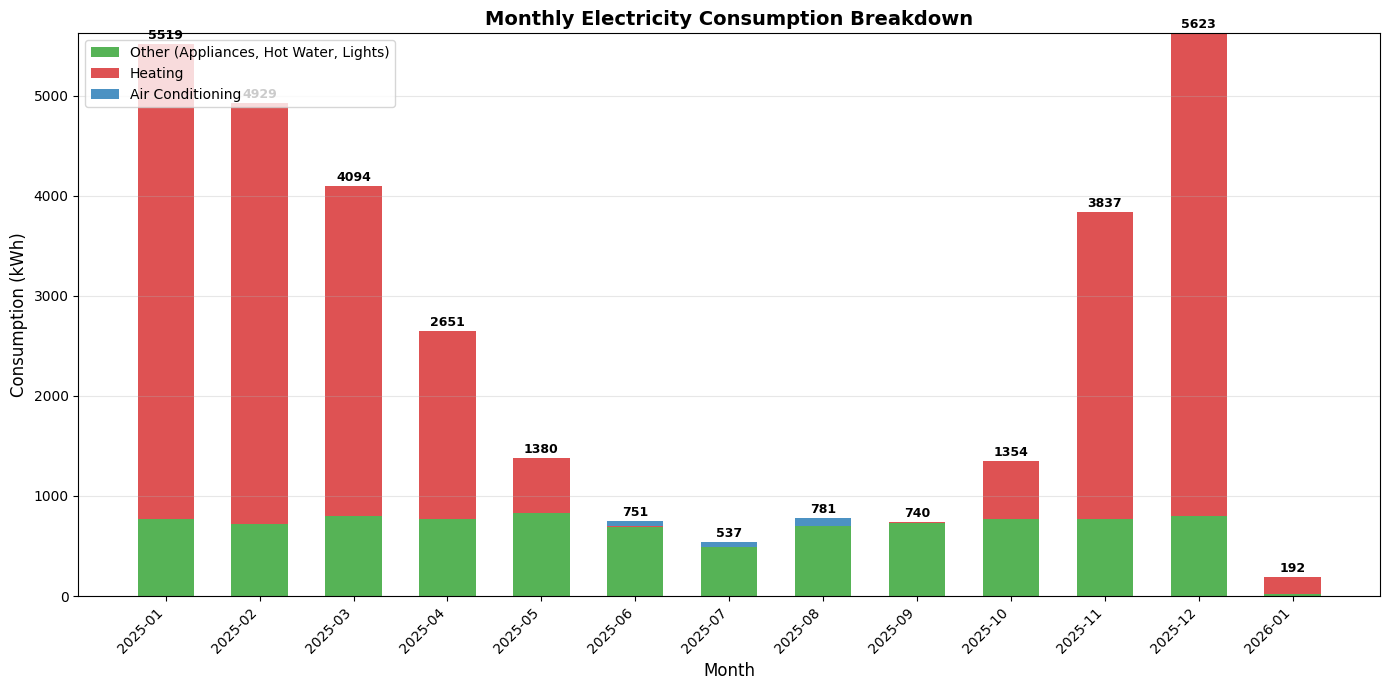


PERCENTAGE BREAKDOWN BY MONTH
            Heating %  Cooling %  Other %
date                                     
2025-01-31       86.0        0.0     14.0
2025-02-28       85.4        0.0     14.6
2025-03-31       80.5        0.0     19.5
2025-04-30       70.9        0.0     29.1
2025-05-31       39.7        0.0     60.3
2025-06-30        0.4        7.3     92.2
2025-07-31        0.0        7.8     92.2
2025-08-31        0.0       10.8     89.1
2025-09-30        1.5        0.0     98.5
2025-10-31       42.9        0.0     57.1
2025-11-30       79.9        0.0     20.1
2025-12-31       85.8        0.0     14.2
2026-01-31       86.6        0.0     13.4


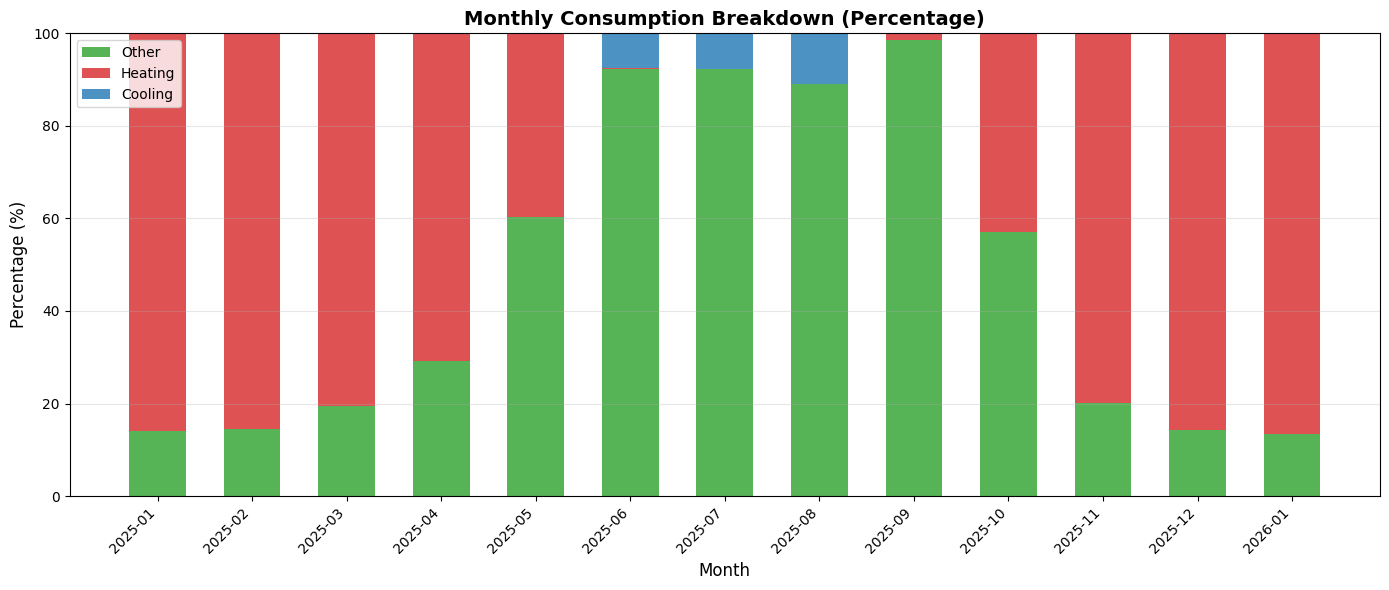


ANNUAL SUMMARY
Total consumption: 32385.50 kWh
  Heating: 23334.50 kWh (72.1%)
  Cooling: 181.60 kWh (0.6%)
  Other: 8869.40 kWh (27.4%)


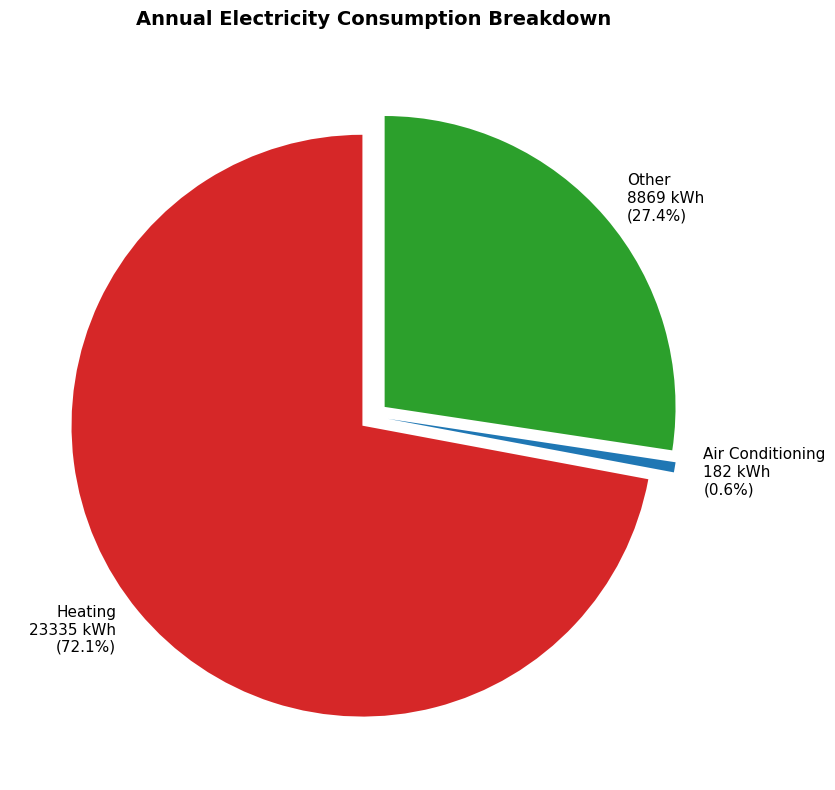

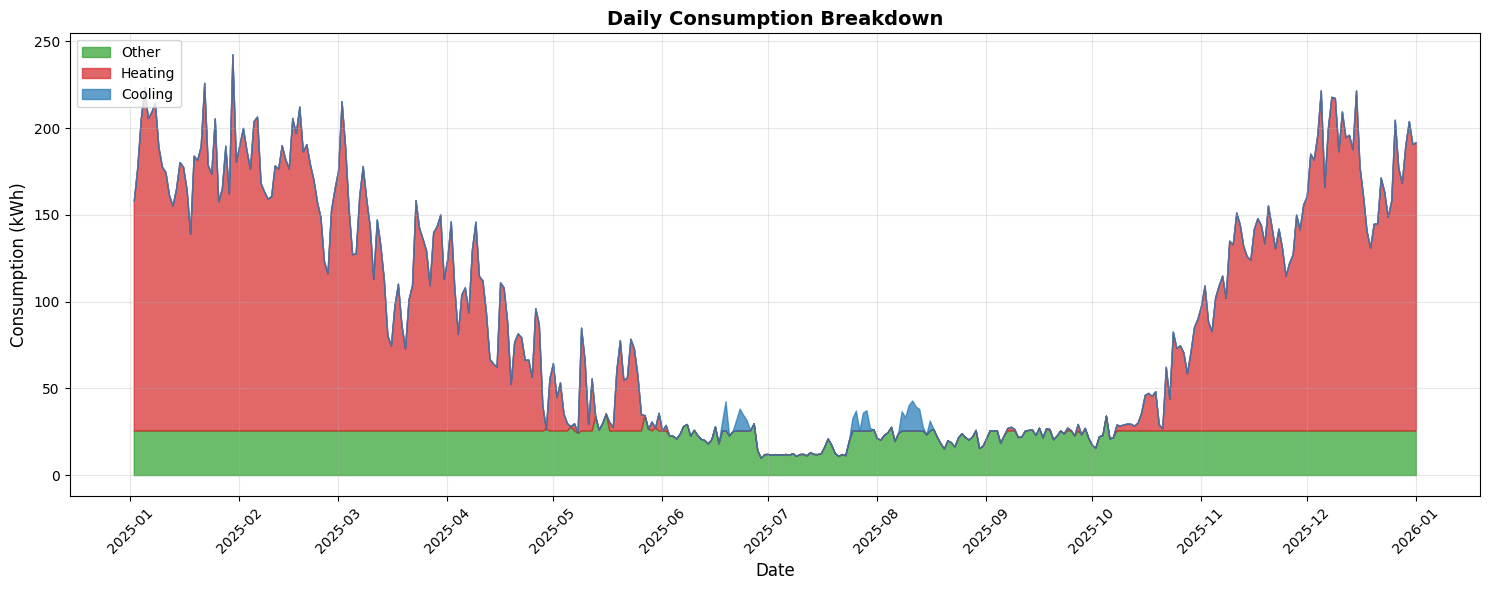


✓ Monthly breakdown saved to: hydro_monthly_breakdown_2025-01-02_to_2026-01-02.csv
✓ Daily breakdown saved to: hydro_daily_breakdown_2025-01-02_to_2026-01-02.csv

IMPORTANT NOTES

This breakdown is an ESTIMATION based on temperature correlation:
- Baseline consumption estimated from mild weather (15-20°C)
- Heating estimated for temperatures < 18°C
- Cooling estimated for temperatures > 22°C
- Other includes: appliances, hot water, lighting, electronics

For more accurate breakdowns, Hydro-Québec's web portal offers
the Energy Performance Indicator which uses detailed home
characteristics and machine learning algorithms.

These estimates are useful for understanding general patterns
and comparing seasonal variations in your energy use.



In [1]:

# ## 11. Important Notes

print(f"\n{'='*60}")
print("IMPORTANT NOTES")
print(f"{'='*60}")
print("""
This breakdown is an ESTIMATION based on temperature correlation:
- Baseline consumption estimated from mild weather (15-20°C)
- Heating estimated for temperatures < 18°C
- Cooling estimated for temperatures > 22°C
- Other includes: appliances, hot water, lighting, electronics

For more accurate breakdowns, Hydro-Québec's web portal offers
the Energy Performance Indicator which uses detailed home
characteristics and machine learning algorithms.

These estimates are useful for understanding general patterns
and comparing seasonal variations in your energy use.
""")